In [14]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

In [15]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc="2023-05-29T18:15:00.746" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
# nrt=1
# arc=0
required_completeness=0.6
# mode="rt" # scw|rt|arc
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [16]:
t0_utc

'2023-05-29T18:15:00.746'

In [17]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [18]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [19]:
import importlib

In [20]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [21]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-05-29 22:00:40 savchenk-NG-VN7-793G-79EG root[3647410] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-29T22:00:40/IJD
2023-05-29 22:00:40 savchenk-NG-VN7-793G-79EG root[3647410] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-29T18:15:00.746/IJD


(8549.91793037037, 8549.761226041666, 8549.757753819444, 8549.764698263889)

In [22]:
lcs={}


In [23]:
def get_rtlc(t0_utc, tstop_rel_seconds):
    url = f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json&prophecy"
    print("url:", url)
    r = requests.get(url)
    return np.array(r.json()['lc']['data'])

if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')

    print("got lc from service of", lcs['ACS'])

    lcs['ACS'][:,1] = 0.05
    print("got ACS", lcs['ACS'])
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

import requests


if rt == 1:
    lc = get_rtlc(t0_utc, tstop_rel_seconds)
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-05-29T18:15:00.746/300
got lc from service of [[8.54975775e+03 1.94778666e-02 4.53200000e+03 6.54007655e+04]
 [8.54975775e+03 6.94790098e-02 4.54000000e+03 6.54008155e+04]
 [8.54975776e+03 1.19478267e-01 4.56200000e+03 6.54008655e+04]
 ...
 [8.54976470e+03 5.99869865e+02 4.51600000e+03 6.60006159e+04]
 [8.54976470e+03 5.99919866e+02 4.51000000e+03 6.60006659e+04]
 [8.54976470e+03 5.99969866e+02 4.52800000e+03 6.60007159e+04]]
got ACS [[8.54975775e+03 5.00000000e-02 4.53200000e+03 6.54007655e+04]
 [8.54975775e+03 5.00000000e-02 4.54000000e+03 6.54008155e+04]
 [8.54975776e+03 5.00000000e-02 4.56200000e+03 6.54008655e+04]
 ...
 [8.54976470e+03 5.00000000e-02 4.51600000e+03 6.60006159e+04]
 [8.54976470e+03 5.00000000e-02 4.51000000e+03 6.60006659e+04]
 [8.54976470e+03 5.00000000e-02 4.52800000e+03 6.60007159e+04]]


https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-05-29T12:15:00.746/10
url: https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/2023-05-29T12:15:00.746/10?json&prophecy


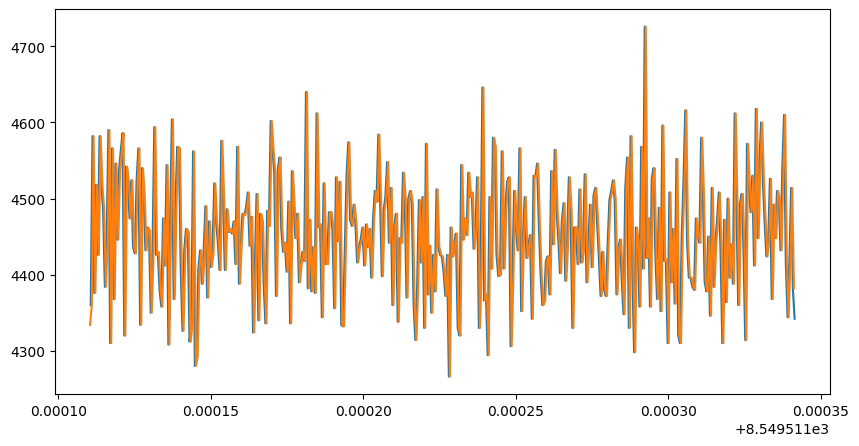

In [24]:
import isdcclient

IC = isdcclient.ISDCClient()

from astropy.time import Time

try:
    t_ref = Time(Time(t0_utc).mjd - 6/24, format='mjd').isot

    scwlc_ref = IC.genlc("ACS", t_ref, 10, format='numpy')
    rtlc_ref = get_rtlc(t_ref, 10)


    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(rtlc_ref[:,1], rtlc_ref[:,0], label="ACS RT")
    plt.plot(scwlc_ref[:,0], scwlc_ref[:,2], label="ACS")
    #TODO: for extra timing accuracy, extract here
except Exception as e:
    print("failed to get ref lc", e)

(-5.0, 5.0)

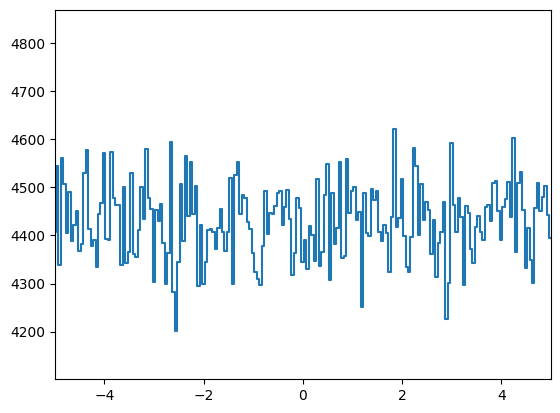

In [25]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-5,5)

In [26]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [27]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

In [28]:
# lcs['ACS']

lcs['ACS'][:,0].min()

8549.757754044882

total lc (12000, 4)
min -0.0034719967843557242
max 0.003471873444141238
expected telapse 600.0 telapse 599.9503877421375 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 88860.72333333331, 'maxrate': 96679.99999999999, 'stdvar': 1557.9756983948398, 'meanerr': 1333.122074930374, 'excvar': 1.1686669418299216, 'maxsnr': 4.811633078841111, 'localfar': 0.008982120141959824, 'localfar_s': 2.612733919964726}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 88860.34842043843, 'maxrate': 90933.33333333331, 'stdvar': 535.1001417248602, 'meanerr': 444.3730875450353, 'excvar': 1.2041686517989914, 'maxsnr': 3.829600979733661, 'localfar': 0.08554607976679657, 'localfar_s': 1.719375173758909}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate': 88

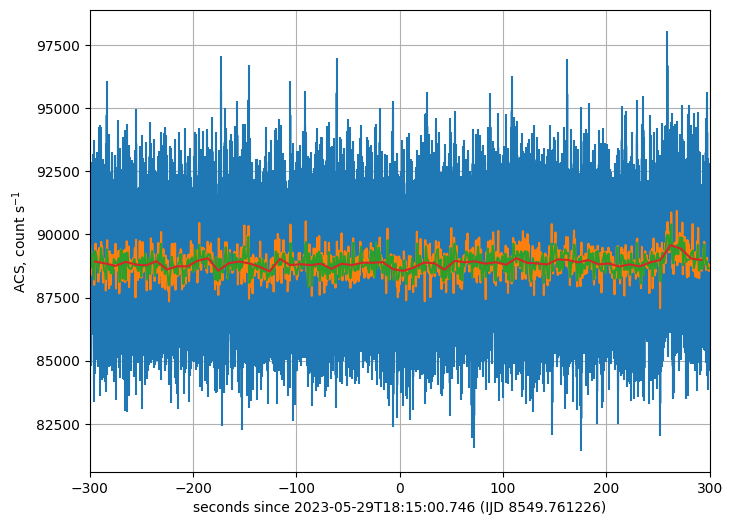

In [29]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [30]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

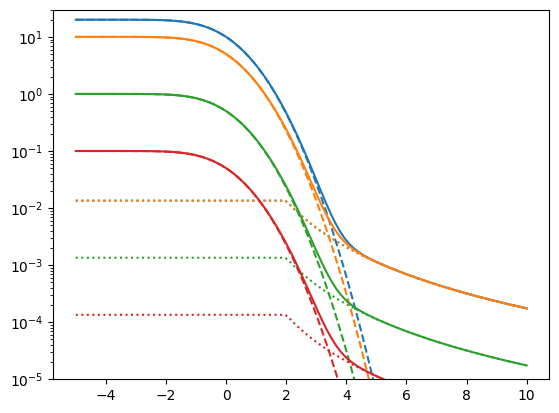

In [31]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [32]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 4)
min -0.0034719967843557242
max 0.003471873444141238
expected telapse 600.0 telapse 599.9503877421375 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1686669418299216
11180 4.811633078841111 259.0198387450073
scale 0.05000000000000001 offset 0 found excesses 22
requested scale 0.1
true scale 0.10000000000000002
offset 0 rebinned to (6000,)
summary_scale['excvar'] 1.1646281662474383
5590 5.100923737697955 259.0448393166298
scale 0.10000000000000002 offset 0 found excesses 13
offset 1 rebinned to (5999,)
summary_scale['excvar'] 1.1809351153229581
5589 3.5489581532106276 258.9948391163489
scale 0.10000000000000002 offset 1 found excesses 8
requested scale 0.15000000000000002
true scale 0.15000000000000002
offset 0 rebinned to (4000,)
summary_scale['excvar'] 1.1862441351242248
74 3.2803475795524455 -288.8305155385751
scale 0.15000000000000002 offset 0 found exces

{'localfar_s': 4.315165504049701,
 'scale': 5.5,
 'summary_scale': {'scale_s': 5.500000000000001,
  'meanrate': 88859.66329966328,
  'maxrate': 89929.81818181816,
  'stdvar': 207.50801639593007,
  'meanerr': 127.10744438513662,
  'excvar': 1.632540229250295,
  'maxsnr': 5.126396955783937,
  'maxsnr_t': 260.7948406201004,
  'localfar': 1.5948337237022982e-05,
  'localfar_s': 4.315165504049701,
  'excesses': [{'snr': 5.126396955783937,
    'rel_s_scale': 260.7948406201004,
    'rate': 89929.81818181816,
    'rate_err': 127.87054403989156,
    'rate_overbkg': 1070.1548821548786,
    'FAP': 0.06761491318135565}]}}

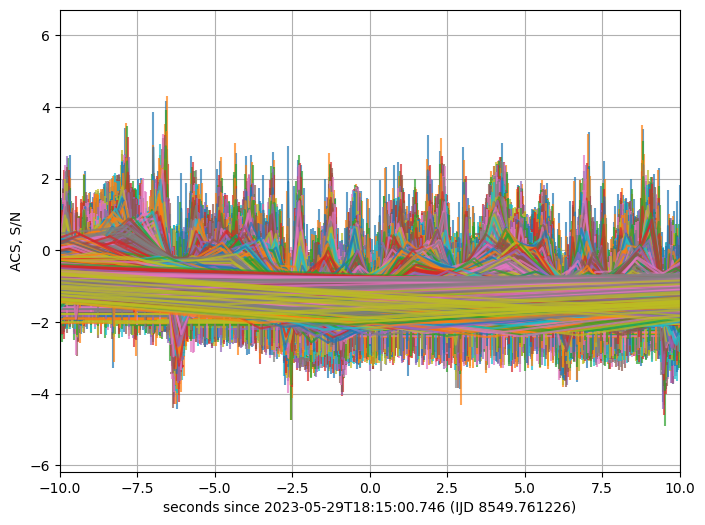

In [33]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    # for ascale in [0.05, 0.1, 0.5]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

(-200.0, 200.0)

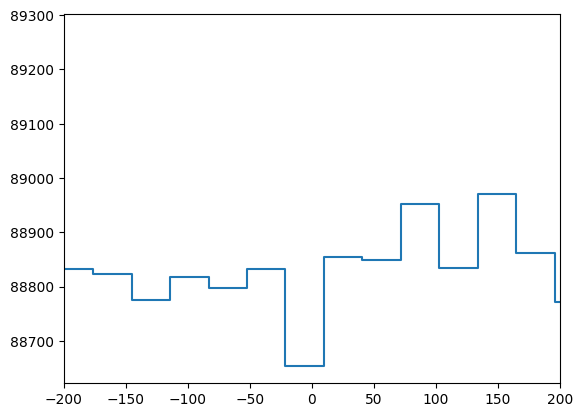

In [34]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [35]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

-283.58051069662906 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.6426496552785768, 'rel_s_scale': -283.58051069662906, 'rate': 94719.99999999999, 'rate_err': 1376.37204272682, 'rate_overbkg': 5859.276666666672, 'FAP': 20.418744627533663}}
-172.98044014605694 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 4.218149521889445, 'rel_s_scale': -172.98044014605694, 'rate': 95679.99999999999, 'rate_err': 1383.3293172632464, 'rate_overbkg': 6819.276666666672, 'FAP': 4.741529536414725}}
-157.23043127800338 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.1586654524548408, 'rel_s_scale': -157.23043127800338, 'rate': 93919.99999999999, 'rate_err': 1370.547335920945, 'rate_overbkg': 5059.276666666672, 'FAP': 41.68860797799009}}
-146.33042156347074 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 4.003004818525763, 'rel_s_scale': -146.33042156347074, 'rate': 95319.99999999999, 'rate_err': 1380.724447527456, 'rate_overbkg': 6459.2766666666

In [36]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

20.350000000000005 140 4.4007079582175885 266.61984449571696 0.029119375986799555
new group
20.350000000000005 130 4.371418515968274 266.1198441560308 0.02971262115445193
to group 266.61984449571696
20.500000000000004 70 4.36634650999508 267.2448449198543 0.02973484847869848
to group 266.61984449571696
20.500000000000004 60 4.363224404755397 266.74484458179836 0.029750313160560246
to group 266.61984449571696
20.500000000000004 90 4.3661019847069 268.2448455480512 0.029851699530079802
to group 266.61984449571696
20.500000000000004 80 4.363458812657808 267.7448452582935 0.029856473597032262
to group 266.61984449571696
20.350000000000005 120 4.360907833400132 265.61984381634466 0.029896359310093823
to group 266.61984449571696
20.500000000000004 40 4.34996297021475 265.7448439076032 0.029943721237142836
to group 266.61984449571696
18.000000000000004 0 4.51902074650731 266.99484473560005 0.03030751303063098
to group 266.61984449571696
group takeover
20.500000000000004 50 4.325761906789892 2

In [37]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print(f"timescale {i['scale']:4.2f}   S/N {i['excess']['snr']:5.2f}   T0+{i['excess']['rel_s_scale']:7.1f}   FAP {i['excess']['FAP']:7.5f}")

timescale 5.50   S/N  5.13   T0+  260.8   FAP 0.06761
timescale 0.45   S/N  3.11   T0+  -12.1   FAP 0.48924
timescale 0.10   S/N  3.30   T0+   -6.6   FAP 0.72878
timescale 0.95   S/N  3.47   T0+  -91.2   FAP 0.73498
timescale 1.10   S/N  3.19   T0+   90.3   FAP 1.20661
timescale 0.20   S/N  3.25   T0+  -19.5   FAP 1.22751
timescale 0.05   S/N  4.17   T0+  -61.0   FAP 1.76606
timescale 0.30   S/N  4.19   T0+  268.2   FAP 2.37059
timescale 1.10   S/N  3.10   T0+ -150.7   FAP 2.55455
timescale 0.40   S/N  3.19   T0+   70.7   FAP 2.59740
timescale 0.55   S/N  3.39   T0+  168.5   FAP 2.75120
timescale 1.00   S/N  3.33   T0+  270.9   FAP 2.80543
timescale 0.05   S/N  3.38   T0+   26.5   FAP 3.77159
timescale 0.35   S/N  3.50   T0+ -194.0   FAP 3.97866
timescale 0.30   S/N  3.10   T0+   75.3   FAP 4.62762
timescale 0.20   S/N  3.19   T0+  -63.8   FAP 4.69368
timescale 0.05   S/N  4.22   T0+ -173.0   FAP 4.74153
timescale 0.05   S/N  4.15   T0+  162.0   FAP 4.82416
timescale 0.05   S/N  4.00  

In [38]:
import json

len(json.dumps(grouped_excesses))

10718

In [39]:
summary['ACS']['best']

{'localfar_s': 4.315165504049701,
 'scale': 5.5,
 'summary_scale': {'scale_s': 5.500000000000001,
  'meanrate': 88859.66329966328,
  'maxrate': 89929.81818181816,
  'stdvar': 207.50801639593007,
  'meanerr': 127.10744438513662,
  'excvar': 1.632540229250295,
  'maxsnr': 5.126396955783937,
  'maxsnr_t': 260.7948406201004,
  'localfar': 1.5948337237022982e-05,
  'localfar_s': 4.315165504049701,
  'excesses': [{'snr': 5.126396955783937,
    'rel_s_scale': 260.7948406201004,
    'rate': 89929.81818181816,
    'rate_err': 127.87054403989156,
    'rate_overbkg': 1070.1548821548786,
    'FAP': 0.06761491318135565}]}}

In [40]:
#T

In [41]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 88860.72333333333,
  'maxrate': 89520.49999999999,
  'stdvar': 176.9153120061184,
  'meanerr': 105.39255389574095,
  'excvar': 1.6786319855303153,
  'maxsnr': 3.7155678999505324,
  'maxsnr_t': 271.9948479525192,
  'localfar': 0.007603042830989499,
  'localfar_s': 2.669207655039385,
  'excesses': [{'snr': 3.482665752963818,
    'rel_s_scale': 263.9948428331263,
    'rate': 89478.99999999999,
    'rate_err': 105.75856939274469,
    'rate_overbkg': 618.2766666666575,
    'FAP': 0.24328082592038894},
   {'snr': 3.7155678999505324,
    'rel_s_scale': 271.9948479525192,
    'rate': 89520.49999999999,
    'rate_err': 105.78309174910702,
    'rate_overbkg': 659.7766666666575,
    'FAP': 0.16166234627131215}]},
 'best': {'localfar_s': 3.897668544145669,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 88859.65202702701,
   'maxrate': 89731.99999999999,
   'stdvar': 184.77325319764904,
   'meanerr': 105.391918586665

In [42]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.169
0.1 1.165
0.15 1.185
0.2 1.184
0.25 1.213
0.3 1.199
0.35 1.194
0.4  1.22
0.45 1.204
0.5 1.225
0.55 1.242
0.6 1.261
0.65 1.252
0.7 1.227
0.75 1.245
0.8 1.215
0.85 1.276
0.9 1.256
0.95 1.255
1 1.285
1.1 1.274
1.15 1.291
1.25 1.266
1.3 1.276
1.4 1.279
1.5 1.312
1.6 1.312
1.7 1.357
1.85  1.39
1.95 1.396
2 1.357
2.1 1.384
2.25 1.358
2.4 1.368
2.5 1.398
2.55 1.383
2.7  1.38
2.9 1.412
3 1.412
3.1  1.48
3.3 1.388
3.5 1.476
3.55 1.381
3.75 1.517
4 1.487
4.3  1.53
4.5 1.614
4.6 1.561
4.9 1.557
5 1.525
5.2 1.625
5.5 1.633
5.55  1.61
5.95 1.559
6 1.662
6.35 1.653
6.5 1.635
6.75 1.722
7 1.708
7.2 1.757
7.5  1.74
7.7 1.803
8 1.753
8.2 1.677
8.5 1.763
8.75 1.798
9 1.801
9.35 1.763
9.5 1.859
10 1.864
10.5 1.914
10.65 1.874
11 1.857
11.35 1.905
11.5 1.991
12 1.831
12.1 1.794
12.5 1.952
12.95 1.929
13 1.977
13.5 2.071
13.8 2.055
14 2.079
14.5 2.143
14.7 2.102
15 2.007
15.5  2.06
15.7 2.141
16 1.979
16.5 2.095
16.75 2.211
17 2.109
17.5 2.151
17.85 2.239
18 2.181
18.5 2.177
19 2.349
19.05 2.301

total lc (12000, 4)
min -0.0034719967843557242
max 0.003471873444141238
total lc (12000, 4)
min -0.0034719967843557242
max 0.003471873444141238
{'scale': 5.500000000000001, 'offset': 51, 'excess': {'snr': 5.126396955783937, 'rel_s_scale': 260.7948406201004, 'rate': 89929.81818181816, 'rate_err': 127.87054403989156, 'rate_overbkg': 1070.1548821548786, 'FAP': 0.06761491318135565}}
(-2.0, 2.0)
total lc (12000, 4)
min -0.0034719967843557242
max 0.003471873444141238
{'scale': 5.500000000000001, 'offset': 51, 'excess': {'snr': 5.126396955783937, 'rel_s_scale': 260.7948406201004, 'rate': 89929.81818181816, 'rate_err': 127.87054403989156, 'rate_overbkg': 1070.1548821548786, 'FAP': 0.06761491318135565}}
(-2.0, 2.0)
{'scale': 0.45000000000000007, 'offset': 3, 'excess': {'snr': 3.1059375068505473, 'rel_s_scale': -12.080336589133367, 'rate': 90559.99999999999, 'rate_err': 448.60276910028585, 'rate_overbkg': 1699.7849462365557, 'FAP': 0.4892416609822236}}
(-2.0, 2.0)
{'scale': 0.10000000000000002, 

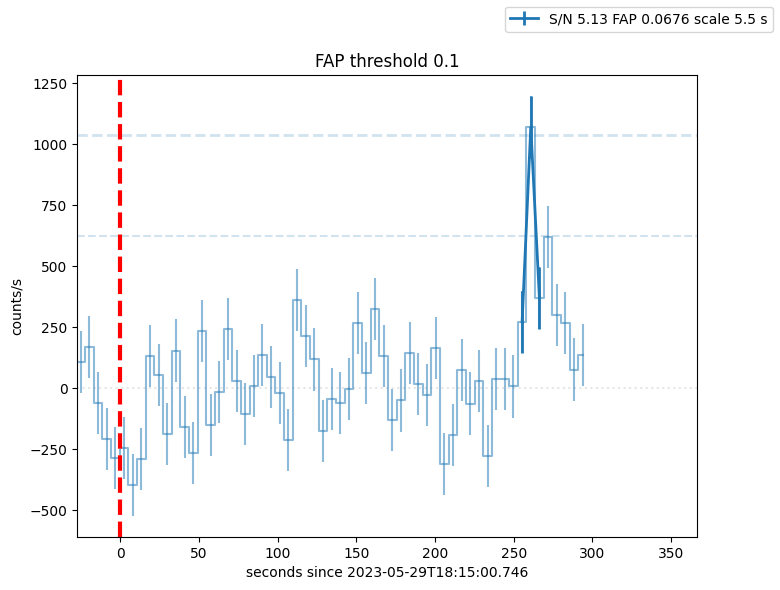

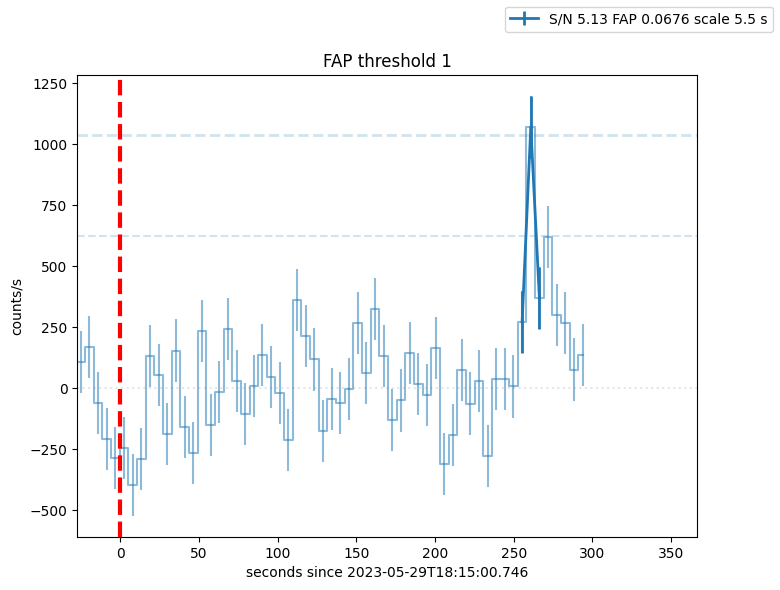

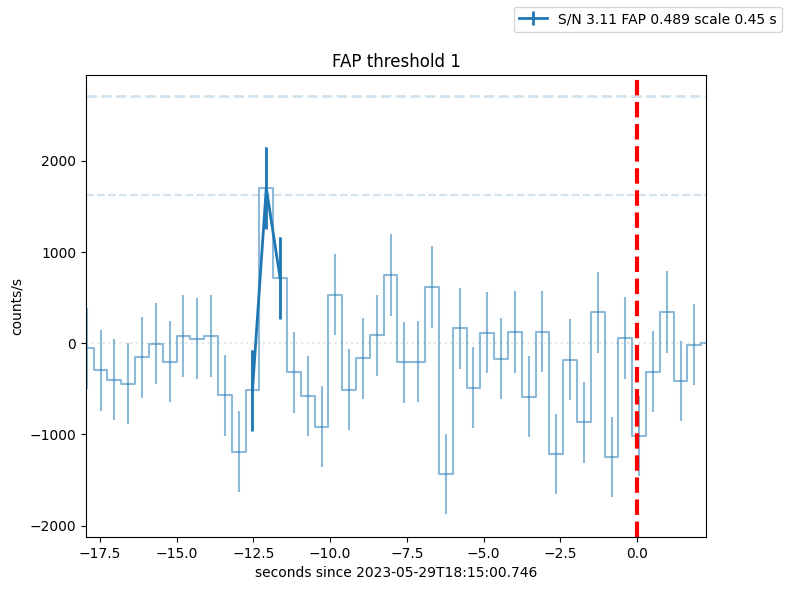

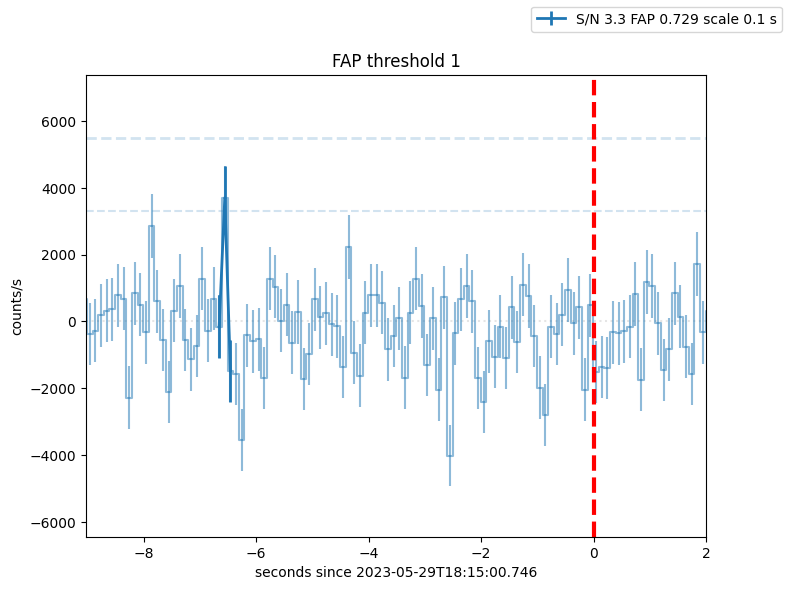

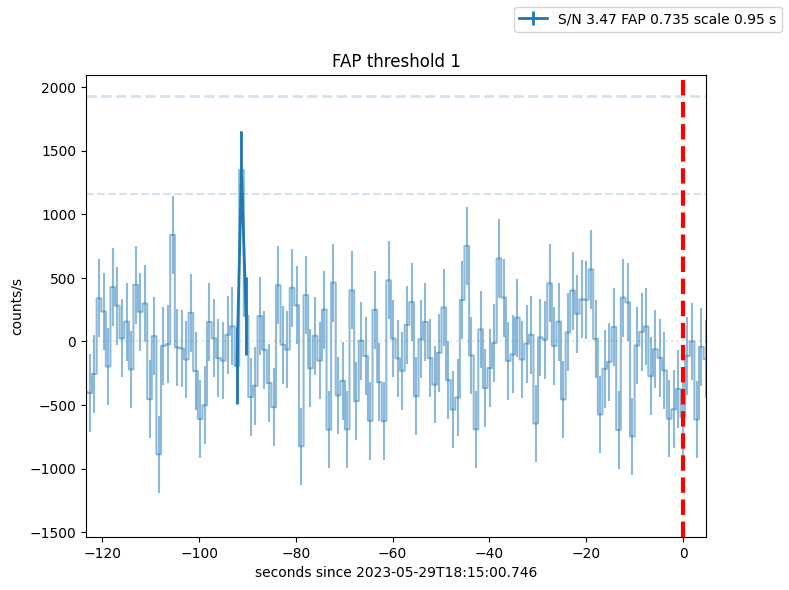

In [43]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


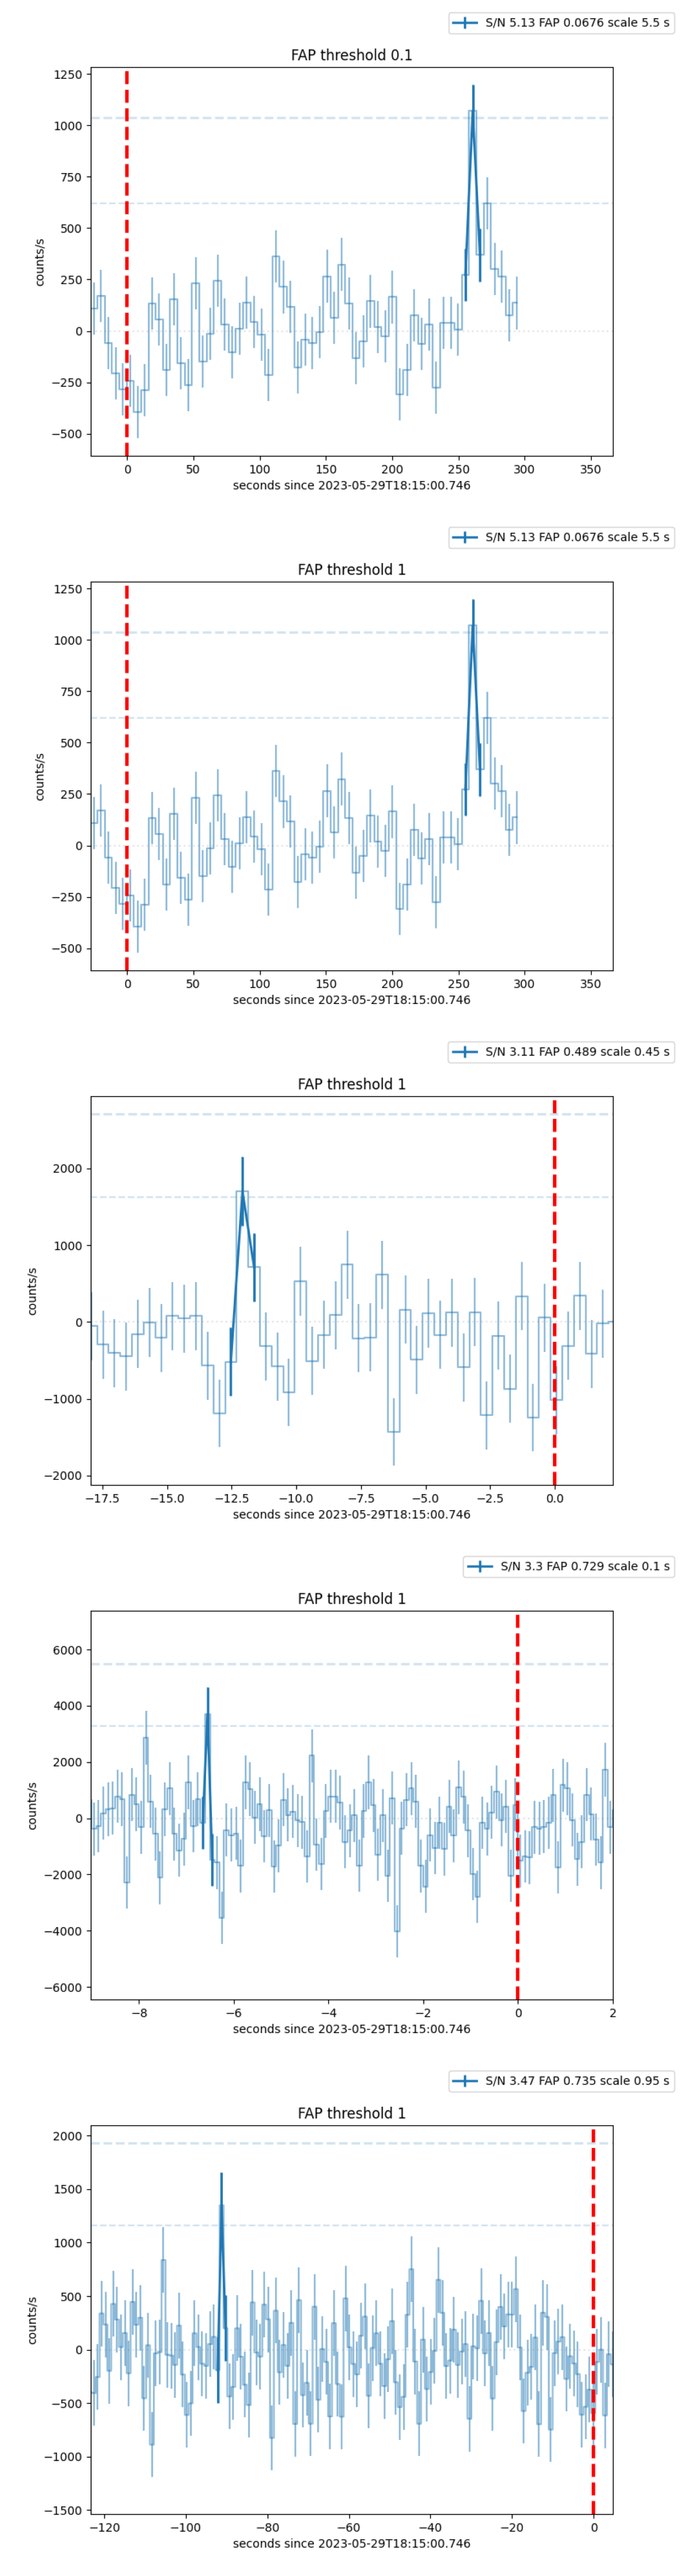

In [44]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [45]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [46]:
summary['ACS']['s_1']['meanerr']

298.0943033495985

In [47]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [48]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary